In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib 
from PIL import Image
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from captum.attr import visualization as viz
sys.path.append("../attacks/")
from utils import get_expl, torch_to_image, load_image,  convert_relu_to_softplus, heatmap_to_image
import mister_ed.loss_functions as lf
import mister_ed.utils.pytorch_utils as mister_ed_utils
from mister_ed.utils.pytorch_ssim import SSIM

### load the images

In [3]:
normalizer = mister_ed_utils.DifferentiableNormalize(mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225])

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])

In [5]:
# image
img = Image.open("../sample_imagenet/sample_0.jpg")
img = torchvision.transforms.ToTensor()(
        torchvision.transforms.CenterCrop(224)(torchvision.transforms.Resize(256)(img)))
img = img.unsqueeze(0).cuda()
# img = normalizer.forward(img).cuda()
# target image
target_img = Image.open("../sample_imagenet/sample_0_target.jpg")
target_img = torchvision.transforms.ToTensor()(
        torchvision.transforms.CenterCrop(224)(torchvision.transforms.Resize(256)(target_img)))
target_img = target_img.unsqueeze(0).cuda()
# target_img = normalizer.forward(target_img).cuda()

In [6]:

##
p_img = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}}
###
for i in ["add", "add_recolor", "add_stadv", "add_stadv_recolor"]:
    for j in ["saliency", "smooth_grad", "uniform_grad", "softplus"]:
        if j == "softplus":
            for file in os.listdir("../examples/output_expl/"+i):
                if file.startswith("x_"):
                    p_img[i][j] = torch.load("../examples/output_expl/"+i+"/"+file)
        else:
            for file in os.listdir("../examples/output_expl_relu/"+i+"/"+j):
                if file.startswith("x_"):
                    p_img[i][j] = torch.load("../examples/output_expl_relu/"+i+"/"+j+"/"+file)

In [8]:
model = torchvision.models.vgg16(pretrained=True).to(device)
#softplus
softplus_model = convert_relu_to_softplus(model, beta=0.8)
softplus_model = softplus_model.eval()
####
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()
idx = model(normalizer.forward(img)).argmax()
print(idx)

tensor(17, device='cuda:0')


In [10]:
sigma = (torch.max(normalizer.forward(img)) - torch.min(normalizer.forward(img))).item() / 5
print("sigma: ", sigma)

sigma:  0.9447309494018554


In [11]:
# original explanations
expl_saliency = get_expl(model, normalizer.forward(img), "saliency", desired_index=idx).detach().cpu()
torch.cuda.empty_cache()
expl_smooth_grad = get_expl(model, normalizer.forward(img), "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
torch.cuda.empty_cache()
expl_uniform_grad = get_expl(model, normalizer.forward(img), "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
torch.cuda.empty_cache()
expl_softplus = get_expl(softplus_model, normalizer.forward(img), "saliency", desired_index=idx).detach().cpu()
torch.cuda.empty_cache()

#perturbed explanations
p_expl = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}}

for i, att in enumerate(["add", "add_stadv", "add_recolor", "add_stadv_recolor"]):
    for j, method in enumerate(["saliency", "smooth_grad", "uniform_grad", "softplus"]):
        perturbed_img = p_img[att][method]
        if method == "smooth_grad":
            expl = get_expl(model, normalizer.forward(perturbed_img), "saliency", desired_index=idx, smooth=True, sigma=sigma)
        elif method == "softplus":
            expl = get_expl(softplus_model, normalizer.forward(perturbed_img), "saliency", desired_index=idx)
        else:
            expl = get_expl(model, normalizer.forward(perturbed_img), method, desired_index=idx, sigma=sigma)
        p_expl[att][method] = expl.detach().cpu()
        del expl
        torch.cuda.empty_cache()

/home/ubuntu/captum/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


### Visualize the results

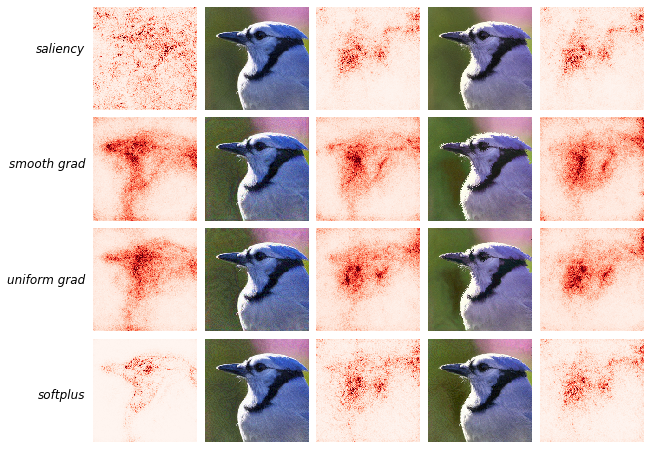

In [12]:


fig, ax = plt.subplots(4, 5, figsize=(10, 8))


viz.visualize_image_attr(np.transpose(expl_saliency.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[0, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_smooth_grad.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[1, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_uniform_grad.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[2, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_softplus.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[3, 0]), use_pyplot=False)

for i, att in enumerate(["add", "add_stadv_recolor"]):
    for j, method in enumerate(["saliency", "smooth_grad", "uniform_grad", "softplus"]):
        perturbed_img = p_img[att][method]
        ax[j, 2*i+1].imshow(torch_to_image(normalizer.forward(perturbed_img), data_mean, data_std))
        viz.visualize_image_attr(np.transpose(p_expl[att][method].squeeze().numpy(), (1,2,0)),
                             np.transpose(perturbed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[j, 2*i+2]), use_pyplot=False)
#################
for i in range(4):
    for j in range(5):
        ax[i,j].axis('off')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
# ax[0, 0].set_title("saliency", fontsize=12)
# ax[0, 1].set_title("smooth grad", fontsize=12)
# ax[0, 2].set_title("uniform grad", fontsize=12)
fig.text(0.12, 0.8, 'saliency', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.6, 'smooth grad', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.4, 'uniform grad', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.2, 'softplus', style = 'oblique', fontsize = 12, horizontalalignment ='right')
# fig.text(0.12, 0.2, 'add+stadv+recolor', style = 'oblique', fontsize = 10, horizontalalignment ='right')
# fig.text(0.12, 0.2, 'Softplus (saliency)', style = 'oblique', fontsize = 20, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.008, hspace=0.07)
plt.savefig("compare_attacks_viz.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

/home/ubuntu/captum/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


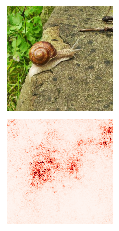

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(2, 4))
target_expl = get_expl(model, normalizer.forward(target_img), "saliency").detach().cpu()
torch.cuda.empty_cache()

ax[0].imshow(torch_to_image(normalizer.forward(target_img), data_mean, data_std))
viz.visualize_image_attr(np.transpose(target_expl.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(target_img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[1]), use_pyplot=False)
ax[0].axis('off')
ax[1].axis('off')
plt.subplots_adjust(wspace=0.008, hspace=0.07)
plt.savefig("target_expl_map.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

### Quantitative comparison

#### MSE

In [14]:
target_map = get_expl(model, normalizer.forward(target_img), "saliency", normalize=True).detach().cpu()
torch.cuda.empty_cache()

In [15]:
mse_to_target_map = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}}

for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
    for method in ["saliency", "smooth_grad", "uniform_grad", "softplus"]:
        normalized_p_expl = torch.sum(p_expl[att][method].squeeze(), 0, True)
        normalized_p_expl = normalized_p_expl / torch.sum(normalized_p_expl)
        mse_to_target_map[att][method] = F.mse_loss(target_map, normalized_p_expl)

In [16]:
mse_to_target_map

{'add': {'saliency': tensor(1.4573e-10),
  'smooth_grad': tensor(5.3058e-10),
  'uniform_grad': tensor(4.3616e-10),
  'softplus': tensor(3.4941e-10)},
 'add_stadv': {'saliency': tensor(1.7103e-10),
  'smooth_grad': tensor(4.6583e-10),
  'uniform_grad': tensor(4.0312e-10),
  'softplus': tensor(1.9984e-10)},
 'add_recolor': {'saliency': tensor(1.3917e-10),
  'smooth_grad': tensor(5.3591e-10),
  'uniform_grad': tensor(4.1775e-10),
  'softplus': tensor(3.0722e-10)},
 'add_stadv_recolor': {'saliency': tensor(1.6067e-10),
  'smooth_grad': tensor(4.7597e-10),
  'uniform_grad': tensor(4.0352e-10),
  'softplus': tensor(1.8527e-10)}}

#### LPIPS similarity for images 

In [17]:
import lpips

In [18]:
lpips_dist = lpips.LPIPS(net='vgg')
if torch.cuda.is_available():
    lpips_dist.cuda()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/ubuntu/PerceptualSimilarity/lpips/weights/v0.1/vgg.pth


In [19]:
lpips_to_original_image = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}}
for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
    for method in ["saliency", "smooth_grad", "uniform_grad", "softplus"]:
        lpips_to_original_image[att][method] = lpips_dist.forward(img, p_img[att][method]).item()

In [20]:
lpips_to_original_image

{'add': {'saliency': 0.2089831531047821,
  'smooth_grad': 0.36234116554260254,
  'uniform_grad': 0.3866426348686218,
  'softplus': 0.35549604892730713},
 'add_stadv': {'saliency': 0.23061183094978333,
  'smooth_grad': 0.29085761308670044,
  'uniform_grad': 0.2960606813430786,
  'softplus': 0.3596474528312683},
 'add_recolor': {'saliency': 0.21616153419017792,
  'smooth_grad': 0.3797152638435364,
  'uniform_grad': 0.383480429649353,
  'softplus': 0.3600633442401886},
 'add_stadv_recolor': {'saliency': 0.2469990849494934,
  'smooth_grad': 0.30628588795661926,
  'uniform_grad': 0.31572553515434265,
  'softplus': 0.3579421639442444}}

#### visual quantitative results

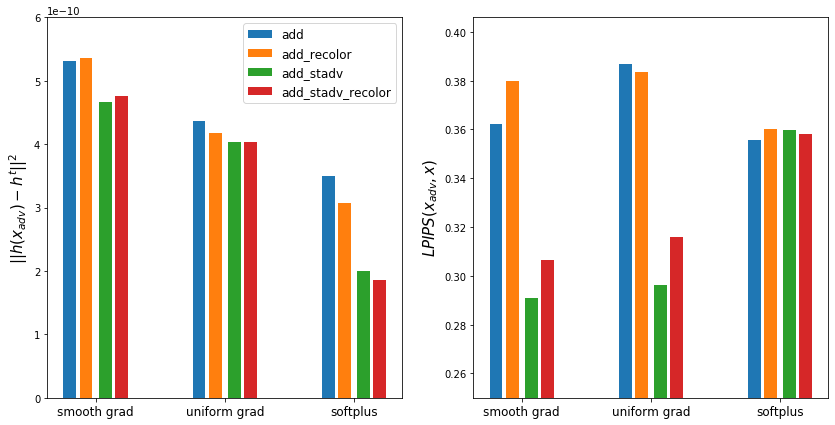

In [25]:
fig, ax = plt.subplots(1,2, figsize=(14, 7))

x_s = np.array([1,2,3])
ax[0].bar(x_s - 0.2, 
           [mse_to_target_map["add"]["smooth_grad"], 
            mse_to_target_map["add"]["uniform_grad"],
            mse_to_target_map["add"]["softplus"]], width=0.1, label="add")

ax[0].bar(x_s - 0.075, 
           [mse_to_target_map["add_recolor"]["smooth_grad"],
            mse_to_target_map["add_recolor"]["uniform_grad"],
            mse_to_target_map["add_recolor"]["softplus"]], width=0.1, label="add_recolor")

ax[0].bar(x_s + 0.075, 
           [mse_to_target_map["add_stadv"]["smooth_grad"],
            mse_to_target_map["add_stadv"]["uniform_grad"],
            mse_to_target_map["add_stadv"]["softplus"]], width=0.1, label="add_stadv")

ax[0].bar(x_s + 0.2, 
           [mse_to_target_map["add_stadv_recolor"]["smooth_grad"],
            mse_to_target_map["add_stadv_recolor"]["uniform_grad"],
            mse_to_target_map["add_stadv_recolor"]["softplus"]], width=0.1, label="add_stadv_recolor")

ax[0].set_xticks(x_s)
ax[0].set_xticklabels(["smooth grad", "uniform grad", "softplus"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].set_ylabel(r"$||h(x_{adv}) - h^t||^2$", fontsize=15)
ax[0].set_ylim(top=6e-10)

ax[1].bar(x_s - 0.2, 
           [lpips_to_original_image["add"]["smooth_grad"],
            lpips_to_original_image["add"]["uniform_grad"],
            lpips_to_original_image["add"]["softplus"]], width=0.1, label="add")

ax[1].bar(x_s - 0.075, 
           [lpips_to_original_image["add_recolor"]["smooth_grad"],
            lpips_to_original_image["add_recolor"]["uniform_grad"],
            lpips_to_original_image["add_recolor"]["softplus"]], width=0.1, label="add_recolor")

ax[1].bar(x_s + 0.075, 
           [lpips_to_original_image["add_stadv"]["smooth_grad"],
            lpips_to_original_image["add_stadv"]["uniform_grad"],
            lpips_to_original_image["add_stadv"]["softplus"]], width=0.1, label="add_stadv")

ax[1].bar(x_s + 0.2, 
           [lpips_to_original_image["add_stadv_recolor"]["smooth_grad"],
            lpips_to_original_image["add_stadv_recolor"]["uniform_grad"],
            lpips_to_original_image["add_stadv_recolor"]["softplus"]], width=0.1, label="add_stadv_recolor")

ax[1].set_xticks(x_s)
ax[1].set_xticklabels(["smooth grad", "uniform grad", "softplus"], fontsize=12)
# ax[1].legend(fontsize=12)
ax[1].set_ylim(bottom=0.25)
ax[1].set_ylabel(r"$LPIPS(x_{adv}, x)$", fontsize=15)
plt.savefig("compare_attacks_mse.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

#### SSIM

In [12]:
ssim_similarity = SSIM()

In [13]:
ssim_to_original_map = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}}

for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
    for method, org_map in zip(["saliency", "smooth_grad", "uniform_grad"], 
                               [expl_saliency, expl_smooth_grad, expl_uniform_grad]):
        ssim_to_original_map[att][method] = ssim_similarity.forward(org_map, p_expl[att][method])

In [14]:
ssim_to_original_map

{'add': {'saliency': tensor(0.4872),
  'smooth_grad': tensor(0.9801),
  'uniform_grad': tensor(0.9248)},
 'add_stadv': {'saliency': tensor(0.5004),
  'smooth_grad': tensor(0.9632),
  'uniform_grad': tensor(0.9183)},
 'add_recolor': {'saliency': tensor(0.4857),
  'smooth_grad': tensor(0.9748),
  'uniform_grad': tensor(0.9242)},
 'add_stadv_recolor': {'saliency': tensor(0.4955),
  'smooth_grad': tensor(0.9670),
  'uniform_grad': tensor(0.9122)}}

#### spearman rank-order correlation

In [15]:
from scipy.stats import spearmanr as spr
import scipy.spatial as spatial

In [16]:
spr_to_original_map = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}}

for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
    for method, org_map in zip(["saliency", "smooth_grad", "uniform_grad"], 
                               [expl_saliency, expl_smooth_grad, expl_uniform_grad]):
        spr_to_original_map[att][method] = spr(org_map.flatten(), p_expl[att][method].flatten())[0]

In [17]:
spr_to_original_map

{'add': {'saliency': 0.13812864846985415,
  'smooth_grad': 0.6853185343601743,
  'uniform_grad': 0.6116536545388386},
 'add_stadv': {'saliency': 0.13435543310168865,
  'smooth_grad': 0.5847530882905764,
  'uniform_grad': 0.618118020844993},
 'add_recolor': {'saliency': 0.13082831144309479,
  'smooth_grad': 0.6399418571554515,
  'uniform_grad': 0.6441179753794173},
 'add_stadv_recolor': {'saliency': 0.13146664326413446,
  'smooth_grad': 0.6049617633483584,
  'uniform_grad': 0.595193332003895}}

#### cosine distance

In [18]:
cosd_to_original_map = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}}

for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
    for method, org_map in zip(["saliency", "smooth_grad", "uniform_grad"], 
                               [expl_saliency, expl_smooth_grad, expl_uniform_grad]):
        cosd_to_original_map[att][method] = float(spatial.distance.cosine(org_map.flatten(), 
                                                                          p_expl[att][method].flatten()))

In [19]:
cosd_to_original_map

{'add': {'saliency': 0.5418198704719543,
  'smooth_grad': 0.16042709350585938,
  'uniform_grad': 0.21913832426071167},
 'add_stadv': {'saliency': 0.5500043332576752,
  'smooth_grad': 0.2441752552986145,
  'uniform_grad': 0.24832648038864136},
 'add_recolor': {'saliency': 0.5490026473999023,
  'smooth_grad': 0.18255573511123657,
  'uniform_grad': 0.23156660795211792},
 'add_stadv_recolor': {'saliency': 0.5533339083194733,
  'smooth_grad': 0.22555547952651978,
  'uniform_grad': 0.272874116897583}}

### CIEDE

In [28]:
##
p_img_ciede = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}}
###
for i in ["add", "add_recolor", "add_stadv", "add_stadv_recolor"]:
    for j in ["smooth_grad", "uniform_grad"]:
        for file in os.listdir("../examples/output_expl_relu/"+i+"/"+j):
            if file.startswith("x_"):
                p_img_ciede[i][j] = normalizer.forward(torch.load("../examples/output_expl_relu/ciede/"+i+"/"+j+"/"+file))

In [29]:

#perturbed explanations
p_expl_ciede = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}}
for i, att in enumerate(["add", "add_stadv", "add_recolor", "add_stadv_recolor"]):
    for j, method in enumerate(["smooth_grad", "uniform_grad"]):
        perturbed_img = p_img_ciede[att][method]
        if method == "smooth_grad":
            expl = get_expl(model, perturbed_img, "saliency", desired_index=idx, smooth=True, sigma=sigma)
        else:
            expl = get_expl(model, perturbed_img, method, desired_index=idx, sigma=sigma)
        p_expl_ciede[att][method] = expl.detach().cpu()
        del expl
        torch.cuda.empty_cache()

#### MSE

In [30]:
mse_to_target_map_ciede = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}}

for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
    for method in ["smooth_grad", "uniform_grad"]:
        normalized_p_expl = torch.sum(p_expl_ciede[att][method].squeeze(), 0, True)
        normalized_p_expl = normalized_p_expl / torch.sum(normalized_p_expl)
        mse_to_target_map_ciede[att][method] = F.mse_loss(target_map, normalized_p_expl)

#### LPIPS

In [31]:
lpips_to_original_image_ciede = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}}
for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
    for method in ["smooth_grad", "uniform_grad"]:
        lpips_to_original_image_ciede[att][method] = lpips_dist.forward(img, p_img_ciede[att][method]).item()

#### viz

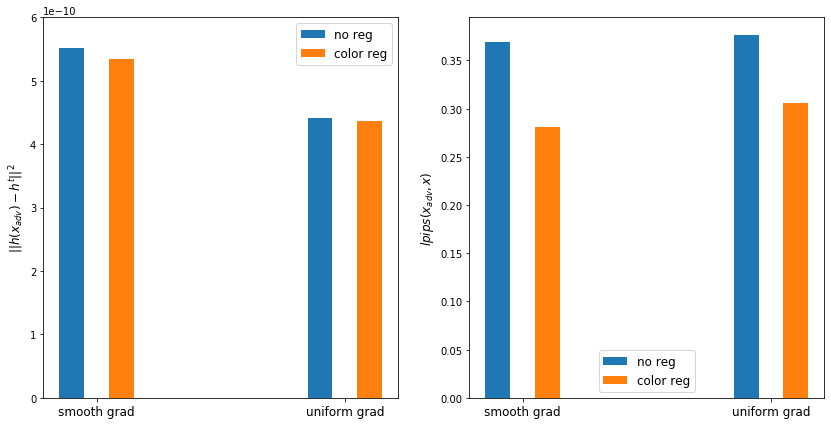

In [32]:
fig, ax = plt.subplots(1,2, figsize=(14, 7))

x_s = np.array([1,2])
ax[0].bar(x_s - 0.1, 
           [mse_to_target_map["add"]["smooth_grad"], mse_to_target_map["add"]["uniform_grad"]], width=0.1, label="no reg")

ax[0].bar(x_s + 0.1, 
           [mse_to_target_map_ciede["add"]["smooth_grad"], mse_to_target_map_ciede["add"]["uniform_grad"]], width=0.1, label="color reg")


ax[0].set_xticks(x_s)
ax[0].set_xticklabels(["smooth grad", "uniform grad"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].set_ylabel(r"$||h(x_{adv}) - h^t||^2$", fontsize=12)
ax[0].set_ylim(top=6e-10)

ax[1].bar(x_s - 0.1, 
           [lpips_to_original_image["add"]["smooth_grad"], lpips_to_original_image["add"]["uniform_grad"]], width=0.1, label="no reg")

ax[1].bar(x_s + 0.1, 
           [lpips_to_original_image_ciede["add"]["smooth_grad"], lpips_to_original_image_ciede["add"]["uniform_grad"]], width=0.1, label="color reg")

ax[1].set_xticks(x_s)
ax[1].set_xticklabels(["smooth grad", "uniform grad"], fontsize=12)
ax[1].legend(fontsize=12)
ax[1].set_ylabel(r"$lpips(x_{adv}, x)$", fontsize=12)
plt.savefig("compare_attacks_mse_ciede.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [3]:
expl_losses = []
with open("../examples/output_expl_relu/add/saliency/output.log", "r") as f:
    for line in f.readlines():
        if line.startswith("expl loss:"):
            expl_losses.append(float(line.strip().split(":")[1]))

In [4]:
expl_losses_add_stadv = []
with open("../examples/output_expl_relu/add_stadv/saliency/output.log", "r") as f:
    for line in f.readlines():
        if line.startswith("expl loss:"):
            expl_losses_add_stadv.append(float(line.strip().split(":")[1]))

In [5]:
expl_losses_add_recolor = []
with open("../examples/output_expl_relu/add_recolor/saliency/output.log", "r") as f:
    for line in f.readlines():
        if line.startswith("expl loss:"):
            expl_losses_add_recolor.append(float(line.strip().split(":")[1]))

In [6]:
expl_losses_add_stadv_recolor = []
with open("../examples/output_expl_relu/add_stadv_recolor/smooth_grad/output.log", "r") as f:
    for line in f.readlines():
        if line.startswith("expl loss:"):
            expl_losses_add_stadv_recolor.append(float(line.strip().split(":")[1]))

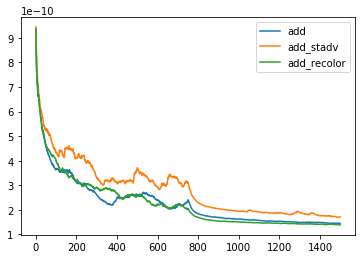

In [11]:
plt.plot(expl_losses, label="add")
plt.plot(expl_losses_add_stadv, label="add_stadv")
plt.plot(expl_losses_add_recolor, label="add_recolor")
# plt.plot(expl_losses_add_recolor, label="add_stadv_recolor")
plt.legend()